In [15]:
import json
import sqlite3
import pandas as pd
import seaborn as sns

In [16]:
conn = sqlite3.connect('./retrieve_data/data_sanitization/data/articles_with_author_mapping.db')

In [17]:
c = conn.cursor()

In [179]:
def encode_abbr(abbr):
    full = '[\"%' + '%'.join(abbr) + '%\"]'
    left = '[\"%' + '%'.join(abbr) + '%\",%]'
    right = '[%,\"%' + '%'.join(abbr) + '%\"]'
    return (full, left, right)

abbr = "jhz"

In [ ]:
# todo: 08.07 Ich zieh mir die top kürzel, mit max und min published
# ich loope über jedes kürzel und hole mir 2-3 autor:inenn die das matchen und deren max/min/ innerhalb des kürzel bereichs liegen +- eine toleranz von 6 montaten oder so

In [180]:
c.execute("select id, url, context_tag, organization, author_array, author_is_abbreviation, published_at from articles where author_array like ? and author_array not like '%,%' ", ('[\"%' + '%'.join(abbr) + '%\"]',))
# and author_array not like '%\%' excludes authors with umlauts because of unicode representation that leads to sqlite like operator recognizing umlaut representation as searched characters

In [181]:
articles = c.fetchall()

In [182]:
print(f"{len(articles)} articles found")

1246 articles found


In [183]:
df = pd.DataFrame(columns=["id", "url", "context_tag", "organization", "author_array", "author_is_abbreviation", "published_at"], data=articles)

In [184]:
df.loc[df['author_array'] == '["' + abbr.upper() + '"]', 'author_array'] = '["' + abbr.lower() + '"]'

In [185]:
# aggregate by quarter of the year
df['published_at'] = pd.to_datetime(df['published_at'])
df['quarter'] = df['published_at'].dt.quarter
df['year'] = df['published_at'].dt.year
df['year_quarter'] = df['year'].astype(str) + "/" + df['quarter'].astype(str)


In [186]:
top_authors = df.groupby('author_array').count()['id'].sort_values(ascending=False).head(4)
top_authors

author_array
["jhz"]                  1054
["Josephine Heinze"]      151
["Jutta Sch\u00fctz"]      15
["Jochen Schmalz"]         13
Name: id, dtype: int64

In [187]:
# get top 5 authors with most articles
top_authors = df.groupby('author_array').count()['id'].sort_values(ascending=False).head(4).index.tolist()
top_authors = top_authors + ['["' + abbr + '"]'] if '["' + abbr + '"]' not in top_authors else top_authors
# filter for top authors
df_top_authors = df[df['author_array'].isin(top_authors)].groupby(['year_quarter', 'author_array']).count()['id'].reset_index()


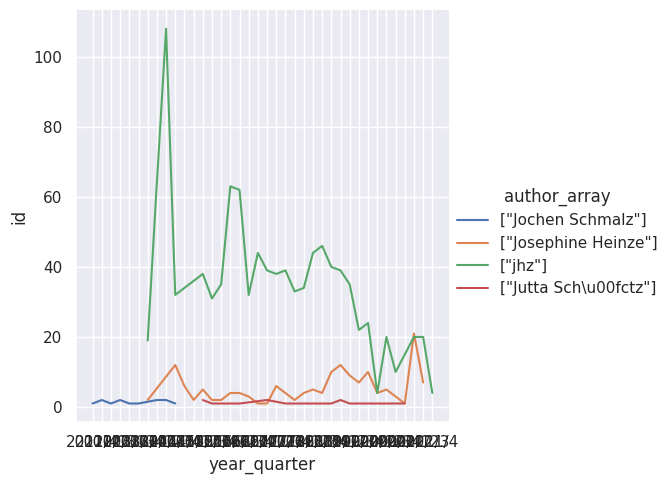

In [188]:

sns.relplot(kind='line', data=df_top_authors, x='year_quarter', y='id', hue='author_array', errorbar=None)
sns.set(rc={'figure.figsize':(14,10)})
#df.groupby('year').count()['id'].plot(kind='bar')

